# Kubeflow Pipelines: from Training to Serving

## Introduction
With [Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/) you can build entire workflows that automate the steps involved in going from training a machine learning model to actually serving an optimized version of it.
These steps can be triggered automatically by a CI/CD workflow or on demand from a command line or notebook.

Kubeflow Pipelines (`kfp`) comes with a user interface for managing and tracking experiments, jobs, and runs.
A pipeline is a description of a machine learning workflow, replete with all inputs and outputs.
In Kubeflow Pipelines, an **experiment** is a [workspace](../metadata/Metadata%20SDK.ipynb) where you can _experiment with_ different configuration of your pipelines.
Experiments are a way to organize runs of jobs into logical groups.
A **run** is simply a single execution (instance) of a pipeline.
Kubeflow Pipelines also supports recurring runs, which is a repeatable run of a pipeline.
Based on a so-called **run trigger** an instance of a pipeline with its run configuration is periodically started.
As of now, [run triggers](https://www.kubeflow.org/docs/pipelines/overview/concepts/run-trigger/) are time-based (i.e. not event-based).

In the UI, there is a pictorial representation of the runtime execution of a pipeline.
This **graph** consists of one or more steps (i.e. nodes).
Each step
The directed edges (arrows) show the parent/child relationship: A &rarr; B means that B depends on A; B cannot start until A has successfully completed.

A **component** performs a single step in the pipeline (e.g. data ingestion, data preprocessing, data transformation, model training, hyperparameter tuning).
It is analogous to a function: it has a name, (metadata) parameters and return values (interface), and a body (implementation).
It must therefore be self-contained.
Each component must be packaged as a Docker image.
Please note that components are independently executed: they do not share the same process and cannot share in-memory data.

### What You'll Learn
This notebook trains a simple (MNIST) model in TensorFlow and serves it with [Seldon](https://www.kubeflow.org/docs/components/serving/seldon/), converts your ML models (Tensorflow, Pytorch, H2o, etc.) or language wrappers (Python, Java, etc.) into production REST/GRPC microservices.
What this means is that you do not have to worry about which machines it runs on, networking, autoscaling, health checks, and what have you.
Instead, you can focus on what matters to you: the model and a REST API you can call for predictions.
If you are familiar with Kubernetes, you can even do [out-of-the-box canary deployments](https://github.com/kubeflow/kfserving/tree/master/docs/samples/tensorflow), in which a percentage of traffic is directed to the 'canary (in the coal mine)' with the latest model to ensure it functions properly before completely rolling out any (potentially problematic) updates.

If you prefer to use a more sophisticated model or a PyTorch-based one, you can check out the relevant notebooks: [MNIST with TensorFlow](../training/tensorflow/MNIST%20with%20TensorFlow.ipynb) or [MNIST with PyTorch](../training/pytorch/MNIST%20with%20PyTorch.ipynb).

KFServing reads the model file from [MinIO](https://min.io/), an open-source S3-compliant object storage tool, which is already included with your Kubeflow installation.

We also use MinIO to provide the input data set to the pipeline. This way it can run without a connection to the Internet.

### What You'll Need
This notebook.

## Prerequisites
Let's make sure Kubeflow Pipelines is available:

In [47]:
! pip install kfp==1.0.1 --user

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached kfp-1.0.1.tar.gz (116 kB)
  Created wheel for kfp: filename=kfp-1.0.1-py3-none-any.whl size=160933 sha256=e73a845410421d0728cb7f93ec5bd5bb1e6328d344e6c91ce46bc5a9f378ca22
  Stored in directory: /home/jovyan/.cache/pip/wheels/fd/88/f8/c59eb844a712adafc79d427cb057b1994c6b3d227893c554a8
Successfully built kfp
  Attempting uninstall: kfp
    Found existing installation: kfp 1.4.0
    Uninstalling kfp-1.4.0:
      Successfully uninstalled kfp-1.4.0


In [22]:
#! pip install --user -U kfp

     |████████████████████████████████| 163kB 36.9MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 92kB 17.7MB/s eta 0:00:01
  Created wheel for docstring-parser: filename=docstring_parser-0.7.3-cp36-none-any.whl size=19230 sha256=745abe7693db35b17dc014a60dee311c5852784932f4e4606be6fd59161e4c85
  Stored in directory: /home/jovyan/.cache/pip/wheels/87/6b/a2/be5c15ac743037f1b006ae4f92a6a81e79a74084cd3ff6fc4c


Successfully built docstring-parser
  Created wheel for kfp: filename=kfp-1.4.0-cp36-none-any.whl size=222156 sha256=5361349d5cb81d9cfc8335de4debe1fb8cba3d9133357777783b840f1ba7299e
  Stored in directory: /home/jovyan/.cache/pip/wheels/6d/7d/29/3dddd13038f8423fd4fdee8bf12a6e547f4c7cde5ff1be1b2d
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=117174 sha256=80dfa2fa4688c65c881896c604c04e433508e6a8af09e3f55bf1068dd8ad2648
  Stored in directory: /home/jovyan/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built kfp fire
  Found existing installation: kfp 1.0.1
    Uninstalling kfp-1.0.1:
      Successfully uninstalled kfp-1.0.1
You should consider upgrading via the 'pip install --upgrade pip' command.


In [48]:
! pip show kfp

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Name: kfp
Version: 1.0.1
Summary: KubeFlow Pipelines SDK
Home-page: UNKNOWN
Author: google
Author-email: None
License: UNKNOWN
Location: /home/jovyan/.local/lib/python3.6/site-packages
Requires: kubernetes, jsonschema, requests-toolbelt, google-auth, click, tabulate, strip-hints, google-cloud-storage, PyYAML, kfp-server-api, cloudpickle, Deprecated
Required-by: 


## How to Configure Credentials
In order for Seldon to access MinIO, the credentials must be added to the default service account.

<div class="alert alert-block alert-info">
    Seldon is imported as a pipeline component (<code>ContainerOp</code>) in this notebook.
    Consequently, it does not allow configuration of custom service accounts.  Encode credentials to base24: <code>echo -n admin:Admin123 | base64</code>
</div>

In [49]:
import logging
import os
import uuid
from importlib import reload
import boto3
from os import environ

In [50]:
from kubernetes import client as k8s_client
from kubernetes.client import rest as k8s_rest
from kubeflow import fairing   
from kubeflow.fairing import utils as fairing_utils
from kubeflow.fairing.builders import append
from kubeflow.fairing.deployers import job
from kubeflow.fairing.preprocessors import base as base_preprocessor

DOCKER_REGISTRY = environ['HARBOR_HOST'] + "/library"
namespace = fairing_utils.get_current_k8s_namespace()

from kubernetes import client as k8s_client
from kubernetes.client.rest import ApiException

api_client = k8s_client.CoreV1Api()


s3_endpoint = environ['AWS_S3_ENDPOINT']
minio_service_endpoint = s3_endpoint
minio_endpoint = "http://"+s3_endpoint
minio_username = environ['AWS_ACCESS_KEY_ID']
minio_key = environ['AWS_SECRET_ACCESS_KEY']
minio_region = "us-east-1"

logging.info(f"Running in namespace {namespace}")
logging.info(f"Using docker registry {DOCKER_REGISTRY}")
logging.info(f"Using minio instance with endpoint '{s3_endpoint}'")

[I 210216 01:42:59 <ipython-input-50-7681aa5604a8>:25] Running in namespace igor
[I 210216 01:42:59 <ipython-input-50-7681aa5604a8>:26] Using docker registry stimulating-ladymaya-962-harbor.app.stimulating-ladymaya-962.bubble.superhub.io/library
[I 210216 01:42:59 <ipython-input-50-7681aa5604a8>:27] Using minio instance with endpoint 'minio.kubeflow-data.svc.cluster.local:9000'


In [5]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [25]:
s3_endpoint = environ['AWS_S3_ENDPOINT']
minio_service_endpoint = s3_endpoint
minio_endpoint = "http://"+s3_endpoint
minio_username = environ['AWS_ACCESS_KEY_ID']
minio_key = environ['AWS_SECRET_ACCESS_KEY']
minio_region = "us-east-1"
MINIO_URL=minio_endpoint
KUBEFLOW_URL=environ['KUBEFLOW_HOST']

In [26]:
%%writetemplate minio_secret.yaml
apiVersion: v1
kind: Secret
metadata:
  name: minio-s3-secret
  annotations:
     serving.kubeflow.org/s3-endpoint: {minio_endpoint}
     serving.kubeflow.org/s3-usehttps: "0" # Default: 1. Must be 0 when testing with MinIO!
type: Opaque
data:
  awsAccessKeyID: {minio_username}
  awsSecretAccessKey: {minio_key}
---
apiVersion: v1
kind: ServiceAccount
metadata:
  name: default
secrets:
  - name: minio-s3-secret

In [27]:
! kubectl apply -f minio_secret.yaml

secret/minio-s3-secret unchanged
serviceaccount/default configured


### Copy input data set into MinIO using its CLI

First, we configure credentials for `mc`, the MinIO command line client.
We then use it to create a bucket, upload the dataset to it, and set access policy so that the pipeline can download it from MinIO.

In [9]:
import logging
import os
import uuid
from importlib import reload
import boto3
from botocore.client import Config

s3 = boto3.client('s3', endpoint_url="http://"+environ['AWS_S3_ENDPOINT'], 
             aws_access_key_id=environ['AWS_ACCESS_KEY_ID'],
             aws_secret_access_key=environ['AWS_SECRET_ACCESS_KEY'],
             region_name='us-east-1')
for _ in s3.list_buckets()["Buckets"]:
  print(_["Name"])

bucket
kubeflow-us-east-1
stimulat-mnist
tutorial


In [10]:
try:
   s3.delete_object(Bucket='tutorial', Key='datasets.tar.gz') 
   s3.delete_bucket(Bucket='tutorial')
except s3.exceptions.from_code('NoSuchBucket'):
    print('No such bucket')

In [11]:
try:
   s3.create_bucket(Bucket='tutorial', ACL='public-read-write')
except s3.exceptions.from_code('BucketAlreadyOwnedByYou'):
    print('Bucket already exists')

In [12]:
s3.upload_file(Filename= r'datasets.tar.gz',
               Bucket='tutorial',
               Key= 'datasets.tar.gz',
               ExtraArgs={'ACL': 'public-read-write'})

In [13]:
s3.list_objects(Bucket='tutorial',MaxKeys=2,Prefix='datasets.tar.gz')['Contents']

[{'Key': 'datasets.tar.gz',
  'LastModified': datetime.datetime(2021, 2, 15, 23, 36, 42, 163000, tzinfo=tzlocal()),
  'ETag': '"b09555beaf4e5cc06d181d24fa9eb2e3-4"',
  'Size': 28440545,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': '',
   'ID': '02d6176db174dc93cb1b899f7c6078f08654445fe8cf1b6ce98d8855f66bdbf4'}}]

## How to Implement Kubeflow Pipelines Components
As we said before, components are self-contained pieces of code: Python functions.

<div class="alert alert-block alert-warning">
    The function must be completely self-contained.
    No code (incl. imports) can be defined outside of the body itself.
    All imports <a href="https://www.kubeflow.org/docs/pipelines/sdk/lightweight-python-components/">must be included</a> in the function body itself!
    Imported packages must be available in the base image.<br><br>
    Why? Because each component will be packaged as a Docker image.
    The base image must therefore contain all dependencies.
    Any dependencies you install manually in the notebook are invisible to the Python function once it's inside the image.
    The function itself becomes the entrypoint of the image, which is why all auxiliary functions must be defined inside the function.
    That does cause some unfortunate duplication, but it also means you do not have to worry about the mechanism of packaging, as we shall see below.
</div>

For our pipeline, we shall define four components:
- Download the MNIST data set
- Train the TensorFlow model
- Evaluate the trained model
- Export the trained model
- Serve the trained model

We also need the current Kubernetes namespace, which we can dynamically grab using [Kubeflow Fairing](../fairing/Kubeflow%20Fairing.ipynb).

In [66]:
from typing import NamedTuple

import kfp
import logging
import kfp.components as components
import kfp.dsl as dsl

from kfp.components import InputPath, OutputPath

namespace = environ['THIS_NAMESPACE']
s3_endpoint = environ['AWS_S3_ENDPOINT']
minio_service_endpoint = s3_endpoint
minio_endpoint = "http://"+s3_endpoint
minio_username = environ['AWS_ACCESS_KEY_ID']
minio_key = environ['AWS_SECRET_ACCESS_KEY']
minio_region = "us-east-1"

logging.info(f"Running in namespace {namespace}")
logging.info(f"Using minio instance with endpoint '{minio_endpoint}'")

[I 210216 01:52:16 <ipython-input-66-4e418488b386>:18] Running in namespace igor
[I 210216 01:52:16 <ipython-input-66-4e418488b386>:19] Using minio instance with endpoint 'http://minio.kubeflow-data.svc.cluster.local:9000'


Function arguments specified with `InputPath` and `OutputPath` are the key to defining dependencies.
For now, it suffices to think of them as the input and output of each step.
How we can define dependencies is explained in the [next section](#How-to-Combine-the-Components-into-a-Pipeline).

### Component 1: Download the MNIST Data Set

In [67]:
def download_dataset(data_dir: OutputPath(str)):
    """Download the MNIST data set to the KFP volume to share it among all steps"""
    import urllib.request
    import tarfile
    import os

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    url = "http://buckets.app.small-julie-379.bubble.superhub.io/tutorial/datasets.tar.gz"
    #url = "http://minio.kubeflow-data.svc.cluster.local:9000/tutorial/datasets.tar.gz"
    stream = urllib.request.urlopen(url)
    tar = tarfile.open(fileobj=stream, mode="r|gz")
    tar.extractall(path=data_dir)

### Component 2: Train the Model
For both the training and evaluation we must divide the integer-valued pixel values by 255 to scale all values into the [0, 1] (floating-point) range.
This function must be copied into both component functions (cf. `normalize_image`).

If you wish to learn more about the model code, please have a look at the [MNIST with TensorFlow](../training/MNIST%20with%20TensorFlow.ipynb) notebook.

In [68]:
def train_model(data_dir: InputPath(str), model_dir: OutputPath(str)):
    """Trains a single-layer CNN for 5 epochs using a pre-downloaded dataset.
    Once trained, the model is persisted to `model_dir`."""

    import os
    import tensorflow as tf
    import tensorflow_datasets as tfds

    def normalize_image(image, label):
        """Normalizes images: `uint8` -> `float32`"""
        return tf.cast(image, tf.float32) / 255.0, label

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=["accuracy"],
    )

    print(model.summary())
    ds_train, ds_info = tfds.load(
        "mnist",
        split="train",
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
        download=False,
        data_dir=f"{data_dir}/datasets",
    )

    # See: https://www.tensorflow.org/datasets/keras_example#build_training_pipeline
    ds_train = ds_train.map(
        normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

    model.fit(
        ds_train,
        epochs=5,
    )

    model.save(model_dir)
    print(f"Model saved {model_dir}")
    print(os.listdir(model_dir))

### Component 3: Evaluate the Model
With the following Python function the model is evaluated.
The metrics [metadata](https://www.kubeflow.org/docs/pipelines/sdk/pipelines-metrics/) (loss and accuracy) is available to the Kubeflow Pipelines UI.
Metadata can automatically be visualized with output viewer(s).
Please go [here](https://www.kubeflow.org/docs/pipelines/sdk/output-viewer/) to see how to do that.

In [69]:
def evaluate_model(
    data_dir: InputPath(str), model_dir: InputPath(str), metrics_path: OutputPath(str)
) -> NamedTuple("EvaluationOutput", [("mlpipeline_metrics", "Metrics")]):
    """Loads a saved model from file and uses a pre-downloaded dataset for evaluation.
    Model metrics are persisted to `/mlpipeline-metrics.json` for Kubeflow Pipelines
    metadata."""

    import json
    import tensorflow as tf
    import tensorflow_datasets as tfds
    from collections import namedtuple

    def normalize_image(image, label):
        return tf.cast(image, tf.float32) / 255.0, label

    ds_test, ds_info = tfds.load(
        "mnist",
        split="test",
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
        download=False,
        data_dir=f"{data_dir}/datasets",
    )

    # See: https://www.tensorflow.org/datasets/keras_example#build_training_pipeline
    ds_test = ds_test.map(
        normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

    model = tf.keras.models.load_model(model_dir)
    (loss, accuracy) = model.evaluate(ds_test)

    metrics = {
        "metrics": [
            {"name": "loss", "numberValue": str(loss), "format": "PERCENTAGE"},
            {"name": "accuracy", "numberValue": str(accuracy), "format": "PERCENTAGE"},
        ]
    }

    with open(metrics_path, "w") as f:
        json.dump(metrics, f)

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])

    return out_tuple(json.dumps(metrics))

### Component 4: Export the Model

In [70]:
def export_model(
    model_dir: InputPath(str),
    metrics: InputPath(str),
    export_bucket: str,
    model_name: str,
    model_version: int,
):
    import os
    import boto3
    from botocore.client import Config

    s3 = boto3.client(
        "s3",
        endpoint_url="http://minio.kubeflow-data.svc.cluster.local:9000",
        aws_access_key_id="e28283b8c53d412c9b03092e58da51e0",
        aws_secret_access_key="d21ade117b8e44508f10e5ae796cf902",
        config=Config(signature_version="s3v4"),
    )

    # Create export bucket if it does not yet exist
    response = s3.list_buckets()
    export_bucket_exists = False

    for bucket in response["Buckets"]:
        if bucket["Name"] == export_bucket:
            export_bucket_exists = True

    if not export_bucket_exists:
        s3.create_bucket(ACL="public-read-write", Bucket=export_bucket)

    # Save model files to S3
    for root, dirs, files in os.walk(model_dir):
        for filename in files:
            local_path = os.path.join(root, filename)
            s3_path = os.path.relpath(local_path, model_dir)

            s3.upload_file(
                local_path,
                export_bucket,
                f"{model_name}/{model_version}/{s3_path}",
                ExtraArgs={"ACL": "public-read"},
            )

    response = s3.list_objects(Bucket=export_bucket)
    print(f"All objects in {export_bucket}:")
    for file in response["Contents"]:
        print("{}/{}".format(export_bucket, file["Key"]))

## How to Combine the Components into a Pipeline
Note that up to this point we have not yet used the Kubeflow Pipelines SDK!

With our four components (i.e. self-contained functions) defined, we can wire up the dependencies with Kubeflow Pipelines.

The call [`components.func_to_container_op(f, base_image=img)(*args)`](https://www.kubeflow.org/docs/pipelines/sdk/sdk-overview/) has the following ingredients:
- `f` is the Python function that defines a component
- `img` is the base (Docker) image used to package the function
- `*args` lists the arguments to `f`

What the `*args` mean is best explained by going forward through the graph:
- `downloadOp` is the very first step and has no dependencies; it therefore has no `InputPath`.
  Its output (i.e. `OutputPath`) is stored in `data_dir`.
- `trainOp` needs the data downloaded from `downloadOp` and its signature lists `data_dir` (input) and `model_dir` (output).
  So, it _depends on_ `downloadOp.output` (i.e. the previous step's output) and stores its own outputs in `model_dir`, which can be used by another step.
  `downloadOp` is the parent of `trainOp`, as required.
- `evaluateOp`'s function takes three arguments: `data_dir` (i.e. `downloadOp.output`), `model_dir` (i.e. `trainOp.output`), and `metrics_path`, which is where the function stores its evaluation metrics.
  That way, `evaluateOp` can only run after the successful completion of both `downloadOp` and `trainOp`.
- `exportOp` runs the function `export_model`, which accepts five parameters: `model_dir`, `metrics`, `export_bucket`, `model_name`, and `model_version`.
  From where do we get the `model_dir`?
  It is nothing but `trainOp.output`.
  Similarly, `metrics` is `evaluateOp.output`.
  The remaining three arguments are regular Python arguments that are static for the pipeline: they do not depend on any step's output being available.
  Hence, they are defined without using `InputPath`.


In [71]:
def train_and_serve(
    data_dir: str,
    model_dir: str,
    export_bucket: str,
    model_name: str,
    model_version: int,
):
    # For GPU support, please add the "-gpu" suffix to the base image
    BASE_IMAGE = "mesosphere/kubeflow:1.0.1-0.5.0-tensorflow-2.2.0"

    downloadOp = components.func_to_container_op(
        download_dataset, base_image=BASE_IMAGE
    )()

    trainOp = components.func_to_container_op(train_model, base_image=BASE_IMAGE)(
        downloadOp.output
    )

    evaluateOp = components.func_to_container_op(evaluate_model, base_image=BASE_IMAGE)(
        downloadOp.output, trainOp.output
    )

    exportOp = components.func_to_container_op(export_model, base_image=BASE_IMAGE)(
        trainOp.output, evaluateOp.output, export_bucket, model_name, model_version
    )


Just in case it isn't obvious: this will build the Docker images for you.
Each image is based on `BASE_IMAGE` and includes the Python functions as executable files.
Each component _can_ use a different base image though.
This may come in handy if you want to have reusable components for automatic data and/or model analysis (e.g. to investigate bias).

Note that you did not have to use [Kubeflow Fairing](../fairing/Kubeflow%20Fairing.ipynb) or `docker build` locally at all!

<div class="alert alert-block alert-info">
    Remember when we said all dependencies have to be included in the base image?
    Well, that was not quite accurate.
    It's a good idea to have everything included and tested before you define and use your pipeline components to make sure that there are not dependency conflicts.
    There is, however, a way to add <a href="https://kubeflow-pipelines.readthedocs.io/en/latest/source/kfp.components.html#kfp.components.func_to_container_op">packages (<code>packages_to_install</code>) and additional code to execute <em>before</em> the function code (<code>extra_code</code>)</a>.
</div>

Is that it?
Not quite!

We still have to define the pipeline itself.
Our `train_and_serve` function defines dependencies but we must use the KFP domain-specific language (DSL) to register the pipeline with its four components:

In [72]:
def op_transformer(op):
    op.add_pod_annotation(name="sidecar.istio.io/inject", value="false")
    return op


@dsl.pipeline(
    name="End-to-End MNIST Pipeline",
    description="A sample pipeline to demonstrate multi-step model training, evaluation, export, and serving",
)
def mnist_pipeline(
    model_dir: str = "/train/model",
    data_dir: str = "/train/data",
    export_bucket: str = "mnist",
    model_name: str = "mnist",
    model_version: int = 1,
):
    train_and_serve(
        data_dir=data_dir,
        model_dir=model_dir,
        export_bucket=export_bucket,
        model_name=model_name,
        model_version=model_version,
    )
    dsl.get_pipeline_conf().add_op_transformer(op_transformer)

With that in place, let's submit the pipeline directly from our notebook:

In [73]:
pipeline_func = mnist_pipeline
run_name = pipeline_func.__name__ + " run"
experiment_name = "End-to-End MNIST Pipeline"

arguments = {
    "model_dir": "/train/model",
    "data_dir": "/train/data",
    "export_bucket": "mnist",
    "model_name": "mnist",
    "model_version": "1",
}

client = kfp.Client()
#client.set_user_namespace("igor")
run_result = client.create_run_from_pipeline_func(
    pipeline_func,
    experiment_name=experiment_name,
    run_name=run_name,
    arguments=arguments,
    namespace=namespace
)

The graph will look like this:

![Graph](./img/graph.png)

If there are any issues with our pipeline definition, this is where they would flare up.
So, until you submit it, you won't know if your pipeline definition is correct.

<div class="alert alert-block alert-info">
    We have so far claimed that Kubeflow Pipelines is for automation of multi-step (ad hoc) workflows and usage in CI/CD.
    You may have wondered why that is.
    After all, it is possible to set up <a href="https://www.kubeflow.org/docs/pipelines/overview/concepts/run/">recurring runs</a> of pipelines.
    The reason is that these pipeline steps are one-offs.
    Even though you can parameterize each step, including the ones that kick off an entire pipeline, there is no orchestration of workflows.
    Stated differently, if a step fails, there is no mechanism for automatic retries.
    Nor is there any support for marking success: if the step is scheduled to be run again, it will be run again, whether or not the previous execution was successful, obviating any subsequent runs (except in cases where it may be warranted).
    Kubeflow Pipelines allows <a href="https://www.kubeflow.org/docs/pipelines/reference/api/kubeflow-pipeline-api-spec/#operation--apis-v1beta1-runs--run_id--retry-post">retries</a> but it is not configurable out of the box.
    If you want Airflow- or Luigi-like behaviour for dependency management of workflows, Kubeflow Pipelines is not the tool.
</div>



## Serve the model with Seldon

* Deploy the model using Seldon
* We need to create
  1. A Kubernetes Deployment
  2. A Kubernetes service
  3. (Optional) Create a configmap containing the prometheus monitoring config

In [219]:
import k8s_util
# Force a reload of kubeflow; since kubeflow is a multi namespace module
# it looks like doing this in notebook_setup may not be sufficient
from kubernetes import client as k8s_client
from kubernetes import config as k8s_config
from kubeflow.tfjob.api import tf_job_client as tf_job_client_module
from IPython.core.display import display, HTML
import yaml

In [226]:
namespace="seldon"

In [227]:
secret_spec = f"""apiVersion: v1
kind: Secret
metadata:
metadata:
  name: seldon-init-container-secret
  namespace: {namespace}
type: Opaque
stringData:
  AWS_ACCESS_KEY_ID: admin
  AWS_SECRET_ACCESS_KEY: Admin123
  AWS_ENDPOINT_URL: https://buckets.app.small-julie-379.bubble.superhub.io/
  USE_SSL: "true"
"""

minio_specs = [secret_spec]


Add admin permissions to the notebook user using the following command: <br>`kubectl create clusterrolebinding workspace-cluster-admin --clusterrole=cluster-admin --serviceaccount=workspace:default-editor`

In [228]:
k8s_util.apply_k8s_specs(minio_specs, k8s_util.K8S_CREATE_OR_REPLACE)

[I 201229 05:52:06 k8s_util:114] Deleted Secret seldon.seldon-init-container-secret
[I 201229 05:52:06 k8s_util:118] Created Secret seldon.seldon-init-container-secret


[{'api_version': 'v1',
  'data': {'AWS_ACCESS_KEY_ID': 'YWRtaW4=',
           'AWS_ENDPOINT_URL': 'aHR0cHM6Ly9idWNrZXRzLmFwcC5zbWFsbC1qdWxpZS0zNzkuYnViYmxlLnN1cGVyaHViLmlvLw==',
           'AWS_SECRET_ACCESS_KEY': 'QWRtaW4xMjM=',
           'USE_SSL': 'dHJ1ZQ=='},
  'kind': 'Secret',
  'metadata': {'annotations': None,
               'cluster_name': None,
               'creation_timestamp': datetime.datetime(2020, 12, 29, 5, 52, 6, tzinfo=tzlocal()),
               'deletion_grace_period_seconds': None,
               'deletion_timestamp': None,
               'finalizers': None,
               'generate_name': None,
               'generation': None,
               'initializers': None,
               'labels': None,
               'managed_fields': None,
               'name': 'seldon-init-container-secret',
               'namespace': 'seldon',
               'owner_references': None,
               'resource_version': '7865882',
               'self_link': '/api/v1/namespaces/seld

In [242]:
export_path="s3://mnist/mnist"
#export_path="s3://small-sa-mnist/mnist/export"
#export_path="gs://seldon-models/tfserving/mnist-model"

In [243]:
deploy_name = "tfserving"
model_base_path = export_path

# The web ui defaults to mnist2-service so if you change it you will
# need to change it in the UI as well to send predictions to the mode
model_service = "mnist2-service"

deploy_spec = f"""apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: {deploy_name}
  namespace: {namespace}
  annotations:        
    sidecar.istio.io/inject: "false"
spec:
  name: mnist
  serviceAccount: default-editor
  predictors:
  - graph:
      children: []
      implementation: TENSORFLOW_SERVER
      modelUri: {model_base_path}
      envSecretRefName: seldon-init-container-secret
      name: mnist
      parameters:
        - name: signature_name
          type: STRING
          value: serving_default
        - name: model_name
          type: STRING
          value: mnist
        - name: model_input
          type: STRING
          value: images
        - name: model_output
          type: STRING
          value: scores     
    name: default
    replicas: 1
"""

service_spec = f"""apiVersion: v1
kind: Service
metadata:
  annotations:    
    prometheus.io/path: /monitoring/prometheus/metrics
    prometheus.io/port: "8500"
    prometheus.io/scrape: "true"
  labels:
    app: mnist-model
  name: {model_service}
  namespace: {namespace}
spec:
  ports:
  - name: grpc-tf-serving
    port: 9000
    targetPort: 9000
  - name: http-tf-serving
    port: 8500
    targetPort: 8500
  selector:
    app: mnist-model
  type: ClusterIP
"""

monitoring_config = f"""kind: ConfigMap
apiVersion: v1
metadata:
  name: {deploy_name}
  namespace: {namespace}
data:
  monitoring_config.txt: |-
    prometheus_config: {{
      enable: true,
      path: "/monitoring/prometheus/metrics"
    }}
"""

model_specs = [deploy_spec, service_spec, monitoring_config]    

In [244]:
k8s_util.apply_k8s_specs(model_specs, k8s_util.K8S_CREATE_OR_REPLACE) 

[I 201229 05:56:27 k8s_util:114] Deleted SeldonDeployment seldon.tfserving
[I 201229 05:56:27 k8s_util:118] Created SeldonDeployment tfserving.tfserving
[I 201229 05:56:27 k8s_util:114] Deleted Service seldon.mnist2-service
[I 201229 05:56:27 k8s_util:118] Created Service seldon.mnist2-service
[I 201229 05:56:27 k8s_util:114] Deleted ConfigMap seldon.tfserving
[I 201229 05:56:27 k8s_util:118] Created ConfigMap seldon.tfserving


[{'apiVersion': 'machinelearning.seldon.io/v1alpha2',
  'kind': 'SeldonDeployment',
  'metadata': {'annotations': {'sidecar.istio.io/inject': 'false'},
   'creationTimestamp': '2020-12-29T05:56:27Z',
   'generation': 1,
   'name': 'tfserving',
   'namespace': 'seldon',
   'resourceVersion': '7867018',
   'selfLink': '/apis/machinelearning.seldon.io/v1alpha2/namespaces/seldon/seldondeployments/tfserving',
   'uid': 'f7e2d7d5-0c09-462d-85f5-3b919cbaaf38'},
  'spec': {'name': 'mnist',
   'predictors': [{'graph': {'children': [],
      'envSecretRefName': 'seldon-init-container-secret',
      'implementation': 'TENSORFLOW_SERVER',
      'modelUri': 's3://mnist/mnist',
      'name': 'mnist',
      'parameters': [{'name': 'signature_name',
        'type': 'STRING',
        'value': 'serving_default'},
       {'name': 'model_name', 'type': 'STRING', 'value': 'mnist'},
       {'name': 'model_input', 'type': 'STRING', 'value': 'images'},
       {'name': 'model_output', 'type': 'STRING', 'value'

## Prepare model input

In [245]:
import matplotlib.pyplot as plt


def display_image(x_test, image_index):
    plt.imshow(x_test[image_index].reshape(28, 28), cmap="binary")


def predict_number(model, x_test, image_index):
    pred = model.predict(x_test[image_index : image_index + 1])
    print(pred.argmax())

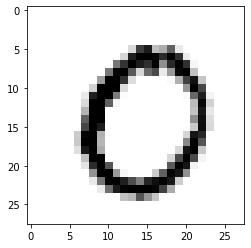

In [246]:
import numpy as np

with np.load("datasets/mnist.npz", allow_pickle=True) as f:
    x_test = (
        f["x_test"] / 255.0
    )  # We must transform the data in the same way as before!

image_index = 101

display_image(x_test, image_index)

In [247]:
darray = x_test[image_index : image_index + 1]

The probabilities for each class (0-9) are shown in the `predictions` response.
The model believes the image shows a "0", which indeed it does!


In [248]:
TOKEN="MTYwOTE5MDExNXxOd3dBTkVnMlRFdGFOMU0zU1ZCSVZGZzBSVmRSUkZwUVYxcEhXVkZNVGxCVFQwWllSRFJOVFZkVVVsVlRUa3BOVFZaTlZEWlhTRUU9fD5h8q0EUw7adNfzGn_F-fpsffnT6wMOoeZ6XdUz2VmM"

In [249]:
from seldon_core.seldon_client import SeldonClient, SeldonChannelCredentials, SeldonCallCredentials
host = "kubeflow.small-julie-379.bubble.superhub.io"
port = "443" # Make sure you use the port above
ISTIO_GATEWAY=host + ":" + port
deployment_name = "tfserving"
transport="rest"
namespace="seldon"

sc = SeldonClient(deployment_name=deployment_name,namespace=namespace,gateway_endpoint=ISTIO_GATEWAY,debug=False,
                 channel_credentials=SeldonChannelCredentials(verify=False),
                 call_credentials=SeldonCallCredentials(token=TOKEN))

In [250]:
r = sc.predict(gateway="istio",transport="rest",data=darray)
print(r)

Success:True message:
Request:
meta {
}
data {
  tensor {
    shape: 1
    shape: 28
    shape: 28
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    values: 0.0
    v

The probabilities for each class (0-9) are shown in the `predictions` response.
The model believes the image shows a "0", which indeed it does!


In [251]:
print (r.response)

{'data': {'names': ['t:0', 't:1', 't:2', 't:3', 't:4', 't:5', 't:6', 't:7', 't:8', 't:9'], 'tensor': {'shape': [1, 10], 'values': [0.999834538, 3.01934335e-07, 3.16104592e-06, 2.71896312e-07, 2.33503528e-07, 1.41523096e-05, 2.49492296e-05, 0.000119655379, 2.53527077e-07, 2.52412633e-06]}}, 'meta': {}}


Congratulations, you have completed the tutorial!